# PyTorch Workflow

Example of PyTorch end-to-end

In [55]:
what_were_covering = {1: "prepare and load data",
                      2: "build model",
                      3: "fit model to data (training)",
                      4: "making predictions/evalutate model (inference)",
                      5: "saving and loading a model",
                      6: "putting it all together"}

In [56]:
what_were_covering

{1: 'prepare and load data',
 2: 'build model',
 3: 'fit model to data (training)',
 4: 'making predictions/evalutate model (inference)',
 5: 'saving and loading a model',
 6: 'putting it all together'}

In [57]:
import torch
from torch import nn # Neural Network module
import matplotlib.pyplot as plt
torch.__version__

'1.13.1'

## 1. Data Preparing and loading

Data can be anything
- spreadsheet
- images
- videos
- audio
- DNA
- Text

Machine learning has two parts:
1. Get data into a numerical representation
2. Build a model to learn patterns in the representation

Use a linear regression formula to make a straight line with known **parameters**

In [58]:
# Create known parameters
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [59]:
len(X), len(y)

(50, 50)

### Splitting data into training and test sets

- Training Set: 60-80%
- Validation Set: 10-20% (Not always required)
- Testing Set: 10-20%

In [60]:
train_split = int(0.8 * len(X))
train_split

40

In [61]:
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

### Visualize data

In [62]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    """
    Plots training data, test data and compares predictions
    """
    plt.figure(figsize=(10,7))
    
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training Data")
    plt.scatter(test_data, test_labels, c="g", s=4, label="Test Data")
    
    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
        
    plt.legend(prop={"size": 14})
    

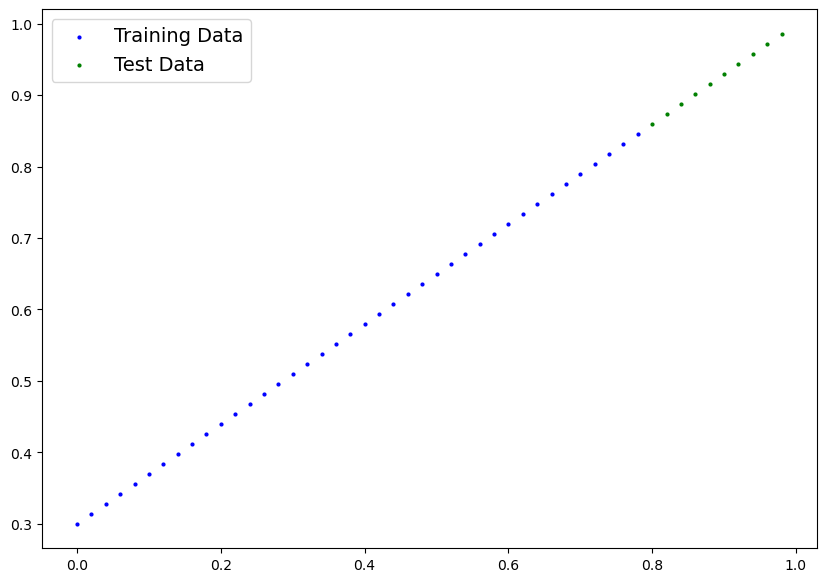

In [63]:
plot_predictions()

## 2. Build model

Two main algorithms:

1. Gradient descent - https://www.youtube.com/watch?v=IHZwWFHWa-w
2. Backpropagation - https://www.youtube.com/watch?v=Ilg3gGewQ5U


In [64]:
# Create a Linear Regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
    def __init__(self):
        super().__init__() 
        self.weights = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
                                                dtype=torch.float), # <- PyTorch loves float32 by default
                                   requires_grad=True) # <- can we update this value with gradient descent?)

        self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
                                            dtype=torch.float), # <- PyTorch loves float32 by default
                                requires_grad=True) # <- can we update this value with gradient descent?))

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)

### PyTorch model building essentials

* torch.nn = contains building blocks for computational graphs (like nns)
* torch.nn.Parameters - parameters model should learn, often set automatically by torch.nn
* torch.nn.Module - base class for all nn modules, must overwrite forward()
* torch.optim - PyTorch optimizers, will help with gradient descent
* def forward() - must be present in all nn.Module subclasses, defines computation to be performed
* torch.utils.data.Dataset - maps between key (label) and sample (features) pairs of data, such as images and associated labels
* torch.utils.data.DataLoader - Creates iterable over torch Dataset


### Checking contents of Model

Check model parameters or what's inside with `.parameters()`.

In [65]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model (subclass of nn.Module)
model_0 = LinearRegressionModel()

#  Check parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [66]:
# List of named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [67]:
# Goal to get closest to ideal values (often unknown)
weight, bias

(0.7, 0.3)

### Making predition using `torch.inference_mode()`

check who well it predicts `y_test` based on `X_test`

When we pass data through our model, will run it through the `forward()` method

In [68]:
X_test, y_test

(tensor([[0.8000],
         [0.8200],
         [0.8400],
         [0.8600],
         [0.8800],
         [0.9000],
         [0.9200],
         [0.9400],
         [0.9600],
         [0.9800]]),
 tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]))

In [69]:
y_preds = model_0(X_test)
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]], grad_fn=<AddBackward0>)

In [70]:
# Make predictions with model
# Turns off gradient tracking - reduces time required
with torch.inference_mode():
    y_preds = model_0(X_test)
    
## This is equivalent and preferred to
# with torch.no_grad():
#   y_preds = model_0(X_Test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [71]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

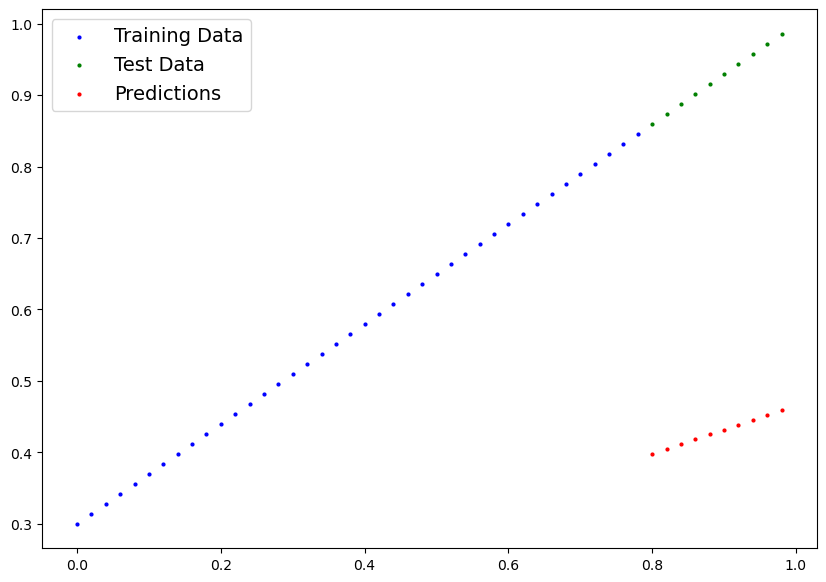

In [72]:
plot_predictions(predictions=y_preds)

## 3. Train model

Right now our model is making predictions using random parameters to make calculations, it's basically guessing (randomly).

To fix that, we can update its internal parameters (I also refer to *parameters* as patterns), the `weights` and `bias` values we set randomly using `nn.Parameter()` and `torch.randn()` to be something that better represents the data.

We could hard code this (since we know the default values `weight=0.7` and `bias=0.3`) but where's the fun in that?

Much of the time you won't know what the ideal parameters are for a model.



### Creating a loss function and optimizer in PyTorch

For our model to update its parameters on its own, we'll need to add a few more things to our recipe.

And that's a **loss function** as well as an **optimizer**.

The rolls of these are: 

| Function | What does it do? | Where does it live in PyTorch? | Common values |
| ----- | ----- | ----- | ----- |
| **Loss function** | Measures how wrong your models predictions (e.g. `y_preds`) are compared to the truth labels (e.g. `y_test`). Lower the better. | PyTorch has plenty of built-in loss functions in [`torch.nn`](https://pytorch.org/docs/stable/nn.html#loss-functions). | Mean absolute error (MAE) for regression problems ([`torch.nn.L1Loss()`](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html)). Binary cross entropy for binary classification problems ([`torch.nn.BCELoss()`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)).  |
| **Optimizer** | Tells your model how to update its internal parameters to best lower the loss. | You can find various optimization function implementations in [`torch.optim`](https://pytorch.org/docs/stable/optim.html). | Stochastic gradient descent ([`torch.optim.SGD()`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD)). Adam optimizer ([`torch.optim.Adam()`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)). | 

Let's create a loss function and an optimizer we can use to help improve our model.

Depending on what kind of problem you're working on will depend on what loss function and what optimizer you use.

However, there are some common values, that are known to work well such as the SGD (stochastic gradient descent) or Adam optimizer. And the MAE (mean absolute error) loss function for regression problems (predicting a number) or binary cross entropy loss function for classification problems (predicting one thing or another). 

For our problem, since we're predicting a number, let's use MAE (which is under `torch.nn.L1Loss()`) in PyTorch as our loss function. 

![what MAE loss looks like for our plot data](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-mae-loss-annotated.png)
*Mean absolute error (MAE, in PyTorch: `torch.nn.L1Loss`) measures the absolute difference between two points (predictions and labels) and then takes the mean across all examples.*

And we'll use SGD, `torch.optim.SGD(params, lr)` where:

* `params` is the target model parameters you'd like to optimize (e.g. the `weights` and `bias` values we randomly set before).
* `lr` is the **learning rate** you'd like the optimizer to update the parameters at, higher means the optimizer will try larger updates (these can sometimes be too large and the optimizer will fail to work), lower means the optimizer will try smaller updates (these can sometimes be too small and the optimizer will take too long to find the ideal values). The learning rate is considered a **hyperparameter** (because it's set by a machine learning engineer). Common starting values for the learning rate are `0.01`, `0.001`, `0.0001`, however, these can also be adjusted over time (this is called [learning rate scheduling](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)). 

Woah, that's a lot, let's see it in code.

In [73]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [74]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [75]:
# Setup loss function
loss_fn = nn.L1Loss()

# Setup optimzer
# use SGD (stochastic gradient descent) currently most popular, Adam is another
optimizer = torch.optim.SGD(params=model_0.parameters(),
                           lr=0.01) # lr = learning rate, .01 changes hundredths, larger lr, larger change in parameter                           

### Building a training and testing loop in PyTorch

A training loop needs:

0. Loop through data and do...
1. Forward pass (data moving through model's forward function(s)) - aka forward propagation
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimize zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss (**backpropagation**)
5. Optimizer step - use the optimizer to adjust model's params to try to improve the loss (**gradient descent**)

In [76]:
torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 200

# Create empty loss lists to track values
loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    model_0.train()

    # 1. Forward pass on train data using the forward() method inside 
    y_pred = model_0(X_train)
    # print(y_pred)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)
    # print(f"Loss: {loss}")

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    model_0.eval() # Turns off settings in the model not needed for evaluation/testing (dropout, batch norm layers)

    with torch.inference_mode(): # turns off gradient tracking and a couple of more things
      # 1. Forward pass on test data
        test_pred = model_0(X_test)

      # 2. Caculate loss on test data
        test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type
        # test_loss = loss_fn(test_pred, y_test)

    # Print out what's happening
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        # train_loss_values.append(loss)
        # test_loss_values.append(test_loss)
        loss_values.append(loss.detach().numpy())
        test_loss_values.append(test_loss.detach().numpy())
        print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")
        print(model_0.state_dict())

Epoch: 0 | MAE Train Loss: 0.31288138031959534 | MAE Test Loss: 0.48106518387794495 
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | MAE Train Loss: 0.1976713240146637 | MAE Test Loss: 0.3463551998138428 
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | MAE Train Loss: 0.08908725529909134 | MAE Test Loss: 0.21729660034179688 
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | MAE Train Loss: 0.053148526698350906 | MAE Test Loss: 0.14464017748832703 
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | MAE Train Loss: 0.04543796554207802 | MAE Test Loss: 0.11360953003168106 
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | MAE Train Loss: 0.04167863354086876 | MAE Test Loss: 0.09919948130846024 
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | MAE Train Loss: 0.03818932920694351 

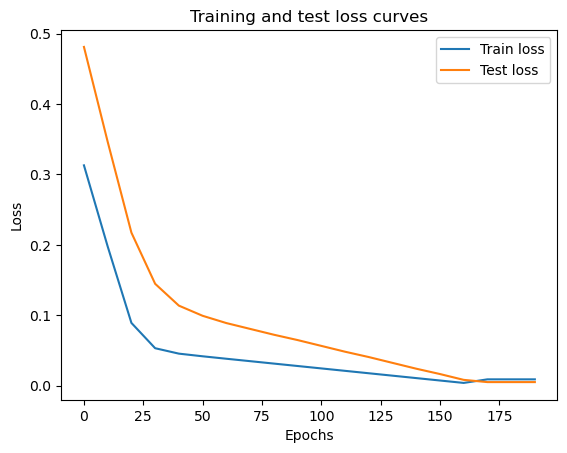

In [77]:
plt.plot(epoch_count, loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [78]:
with torch.inference_mode():
    y_preds_new = model_0(X_test)

In [79]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [80]:
weight, bias

(0.7, 0.3)

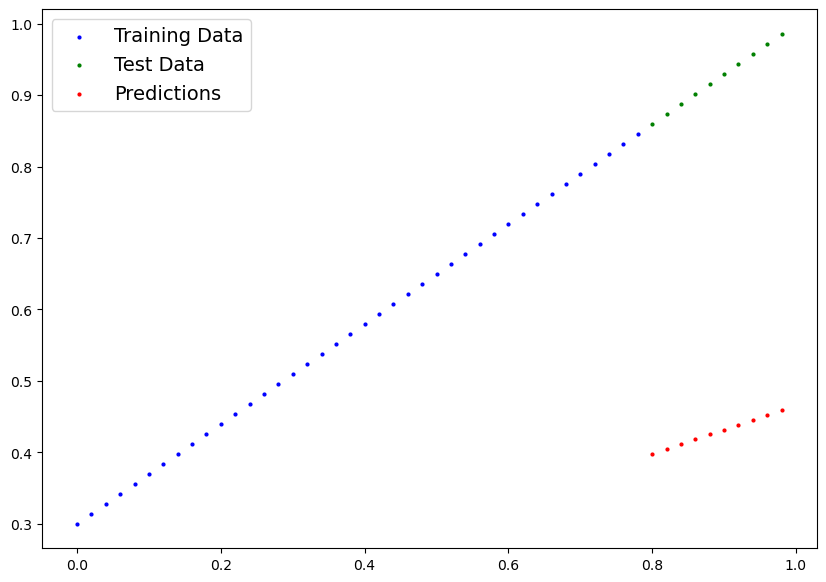

In [81]:
plot_predictions(predictions=y_preds)

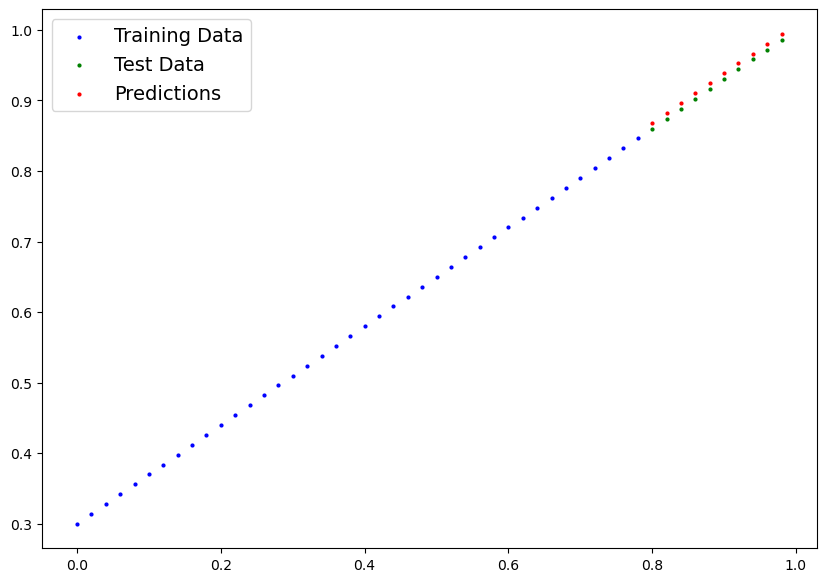

In [82]:
plot_predictions(predictions=y_preds_new)

### Saving and loading a model in PyTorch

There are three main methods

1. `torch.save()` - saves PyTorch object in Python pickle format
2. `torch.load()` - loads a saved object
3. `torch.nn.Module.load_state_dict()` - load a models saved state

In [83]:
# Saving our PyTorch model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "my_pyt_01_workflow_model_0.pt"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save model state_dict
print(f"Saving to {MODEL_SAVE_PATH}")
torch.save(model_0.state_dict(), MODEL_SAVE_PATH)

Saving to models/my_pyt_01_workflow_model_0.pt


In [84]:
ls -l models

total 4
-rw-rw-r-- 1 biscotty biscotty 1203 Dec 21 13:51 my_pyt_01_workflow_model_0.pt


### Loading a PyTorch Model

Since we saved the model's state_dict() only must create a new instance and load the saved state into that

In [85]:
loaded_model_0 = LinearRegressionModel()
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [86]:
# Make some predictions
loaded_model_0.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)
loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [87]:
# Make some model preds
model_0.eval()
with torch.inference_mode():
    y_preds = model_0(X_test)

In [88]:
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 6. Putting it all together

In [89]:
import torch
from torch import nn
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'1.13.1'

Create device-agnostic code to access gpu if available

In [90]:
device = "cuda" if torch.cuda.is_available else "cpu"
print(f"Using device: {device}")

Using device: cuda


### 6.1 Data

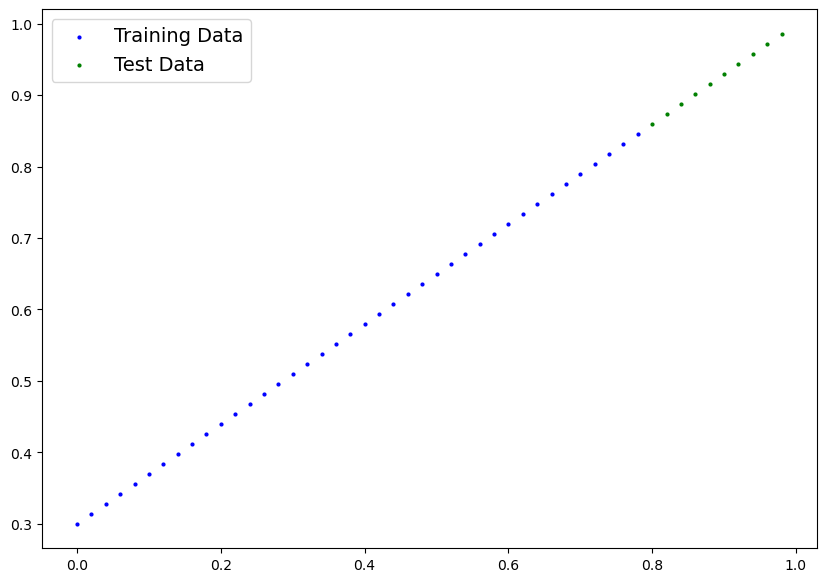

In [91]:
# Create data using the linear regression formula y = x * weight + bias
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

# X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

train_split = int(0.8 * len(X))
X_train, X_test = X[:train_split], X[train_split:]
y_train, y_test = y[:train_split], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

plot_predictions(X_train, y_train, X_test, y_test)

### 6.2 PyTorch Linear Model

In [92]:
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear() for creating the model parameters
        self.linear_layer = nn.Linear(in_features=1,
                                      out_features=1)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)
    
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [93]:
# Set model to target device
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

### 6.3 Training
- Loss function
- Optimzer
- Training loop
- Testing loop

In [94]:
# Setup loss function
loss_fn = nn.L1Loss()

# Setup optimzer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.01)

# Put data on device-agnostic device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

# Training loop
torch.manual_seed(42)
epochs = 200

for epoch in range(epochs):
    # set model to training mode
    model_1.train()
    
    # 1. Forward pass (predictions)
    y_pred = model_1(X_train)
    
    # 2. Calulate loss
    loss = loss_fn(y_pred, y_train)
    
    # 3. Zero the optimizer
    optimizer.zero_grad()
    
    # 4. Perform backpropagation
    loss.backward()
    
    # 5. Optimizer step
    optimizer.step()
    
    ### Testing
    model_1.eval()
    with torch.inference_mode():
      test_pred = model_1(X_test)
      test_loss = loss_fn(test_pred, y_test)
      
    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
    
    


Epoch: 0 | Loss: 0.5551779866218567 | Test loss: 0.5739762187004089
Epoch: 10 | Loss: 0.439968079328537 | Test loss: 0.4392664134502411
Epoch: 20 | Loss: 0.3247582018375397 | Test loss: 0.30455657839775085
Epoch: 30 | Loss: 0.20954833924770355 | Test loss: 0.16984669864177704
Epoch: 40 | Loss: 0.09433845430612564 | Test loss: 0.03513690456748009
Epoch: 50 | Loss: 0.023886388167738914 | Test loss: 0.04784907028079033
Epoch: 60 | Loss: 0.019956795498728752 | Test loss: 0.045803118497133255
Epoch: 70 | Loss: 0.016517987474799156 | Test loss: 0.037530567497015
Epoch: 80 | Loss: 0.013089174404740334 | Test loss: 0.02994490973651409
Epoch: 90 | Loss: 0.009653178043663502 | Test loss: 0.02167237363755703
Epoch: 100 | Loss: 0.006215683650225401 | Test loss: 0.014086711220443249
Epoch: 110 | Loss: 0.00278724217787385 | Test loss: 0.005814164876937866
Epoch: 120 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 130 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416

In [95]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

### 6.4 Making and evaluating predictions

In [96]:
# Set eval mode
model_1.eval()

# Make predictions
with torch.inference_mode():
  y_preds = model_1(X_test)
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

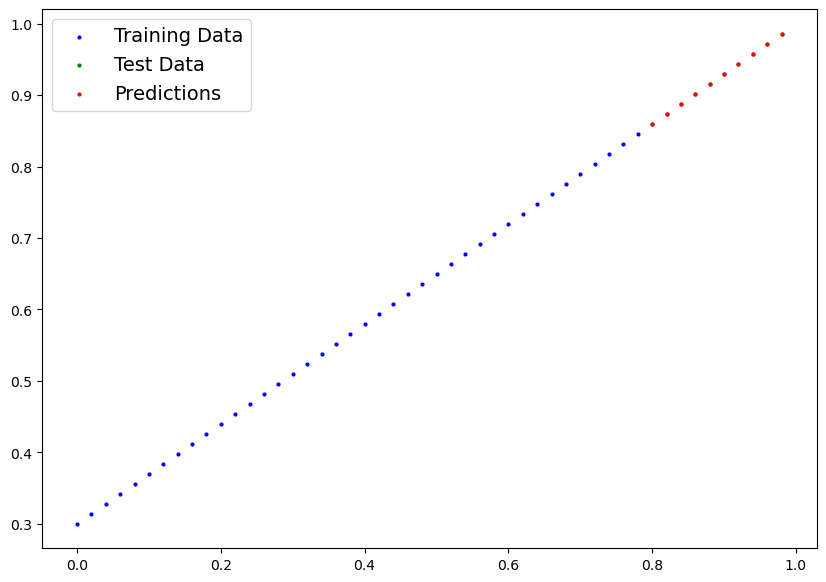

In [97]:
plot_predictions(predictions=y_preds.cpu())

### 6.5 Saving and loading a model

In [99]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "01_pytorch_workflow_model_1.pt"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

MODEL_SAVE_PATH

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pt


In [100]:
# Load a PyTorch module
loaded_model_1 = LinearRegressionModelV2()
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))
loaded_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [101]:
next(loaded_model_1.parameters()).device

device(type='cuda', index=0)

In [102]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [103]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
  loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')